In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


MODELOS = {
    # ano:  [inicial, final]
    "2009": [ 999500,  1220500 ],
    "2010": [ 1220501, 1345500 ],
    "2011": [ 1368501, 1650000 ],
    "2013": [ 1650001, 1701000 ],
    "2015": [ 1750000, 1950000 ],
    "2020": [ 2000000, 2250000 ],
}

ESTADOS = [
    "RS","SC","PR",
    "SP","RJ","MG","ES",
    "MS","MT","GO","DF",
    "BA","SE","AL","PE","PB","RN","CE","PI","MA",
    "TO","PA","RO","AC","AM","AP","RR",
    "ZZ"
]

COLUNAS = [
    "SG_UF","NR_ZONA","NR_SECAO","DS_CARGO_PERGUNTA","NR_LOCAL_VOTACAO","NR_URNA_EFETIVADA","NM_VOTAVEL","QT_APTOS","QT_VOTOS",
]

def modelo_by_urna(urna):
    for modelo, (inicial, final)  in MODELOS.items():
        if inicial <= urna <= final:
            return modelo
    return None


In [2]:
all_dfs = []

for estado in ESTADOS:
    nome_arquivo = f"data/original/bweb_2t_{estado}_311020221535.csv"
    arquivo = pd.read_csv(nome_arquivo, sep=";", encoding="iso-8859-1")
    dfe = pd.DataFrame(arquivo, columns=COLUNAS)
    dfe = dfe[dfe.DS_CARGO_PERGUNTA == "Presidente"]
    dfe = dfe.assign(SY_MODELO_URNA=dfe.NR_URNA_EFETIVADA.apply(modelo_by_urna))
    dfe = dfe.assign(SY_COUNT=1)
    all_dfs.append(dfe)

df = pd.concat(all_dfs)
df

,SG_UF,NR_ZONA,NR_SECAO,DS_CARGO_PERGUNTA,NR_LOCAL_VOTACAO,NR_URNA_EFETIVADA,NM_VOTAVEL,QT_APTOS,QT_VOTOS,SY_MODELO_URNA,SY_COUNT
0,RS,1,1,Presidente,1422,2215453,Branco,355,10,2020,1
1,RS,1,1,Presidente,1422,2215453,JAIR BOLSONARO,355,108,2020,1
2,RS,1,1,Presidente,1422,2215453,Nulo,355,9,2020,1
3,RS,1,1,Presidente,1422,2215453,LULA,355,155,2020,1
8,RS,1,2,Presidente,1325,2213088,Nulo,358,7,2020,1
...,...,...,...,...,...,...,...,...,...,...,...
3963,ZZ,1,3390,Presidente,1031,1023396,JAIR BOLSONARO,639,115,2009,1
3964,ZZ,1,3394,Presidente,1031,1019971,LULA,696,270,2009,1
3965,ZZ,1,3394,Presidente,1031,1019971,JAIR BOLSONARO,696,110,2009,1
3966,ZZ,1,3394,Presidente,1031,1019971,Nulo,696,1,2009,1


In [3]:


secao_colapsado = df.pivot_table(
    columns="NM_VOTAVEL",
    values="QT_VOTOS",
    aggfunc=np.sum,
    fill_value=0,
    index=[
        df.SG_UF, df.NR_ZONA, df.NR_SECAO, df.SY_MODELO_URNA,
        df.NR_LOCAL_VOTACAO, df.NR_URNA_EFETIVADA], 
)
secao_colapsado.to_csv("secao_colapsado.csv")
secao_colapsado


NM_VOTAVEL                                                                Branco  \
SG_UF NR_ZONA NR_SECAO SY_MODELO_URNA NR_LOCAL_VOTACAO NR_URNA_EFETIVADA           
AC    1       3        2020           1279             2046404                 2   
              4        2020           1139             2048249                 2   
              5        2020           1031             2048064                 3   
              6        2020           1031             2043747                 1   
              7        2020           2321             2048283                 0   
...                                                                          ...   
ZZ    1       3363     2009           1031             1010675                 6   
              3374     2015           1031             1815999                 6   
              3386     2009           1031             1017187                 0   
              3390     2009           1031             1023396                 0   
              3394     2009           1031             1019971                 4   

NM_VOTAVEL                                                                JAIR BOLSONARO  \
SG_UF NR_ZONA NR_SECAO SY_MODELO_URNA NR_LOCAL_VOTACAO NR_URNA_EFETIVADA                   
AC    1       3        2020           1279             2046404                        96   
              4        2020           1139             2048249                       167   
              5        2020           1031             2048064                       183   
              6        2020           1031             2043747                       168   
              7        2020           2321             2048283                       192   
...                                                                                  ...   
ZZ    1       3363     2009           1031             1010675                       132   
              3374     2015           1031             1815999                        98   
              3386     2009           1031             1017187                        83   
              3390     2009           1031             1023396                       115   
              3394     2009           1031             1019971                       110   

NM_VOTAVEL                                                                LULA  \
SG_UF NR_ZONA NR_SECAO SY_MODELO_URNA NR_LOCAL_VOTACAO NR_URNA_EFETIVADA         
AC    1       3        2020           1279             2046404              48   
              4        2020           1139             2048249              83   
              5        2020           1031             2048064              72   
              6        2020           1031             2043747              72   
              7        2020           2321             2048283              83   
...                                                                        ...   
ZZ    1       3363     2009           1031             1010675             363   
              3374     2015           1031             1815999             165   
              3386     2009           1031             1017187             245   
              3390     2009           1031             1023396             217   
              3394     2009           1031             1019971             270   

NM_VOTAVEL                                                                Nulo  
SG_UF NR_ZONA NR_SECAO SY_MODELO_URNA NR_LOCAL_VOTACAO NR_URNA_EFETIVADA        
AC    1       3        2020           1279             2046404               1  
              4        2020           1139             2048249               7  
              5        2020           1031             2048064               2  
              6        2020           1031             2043747               4  
              7        2020           2321             2048283               5  
...                                                                        .

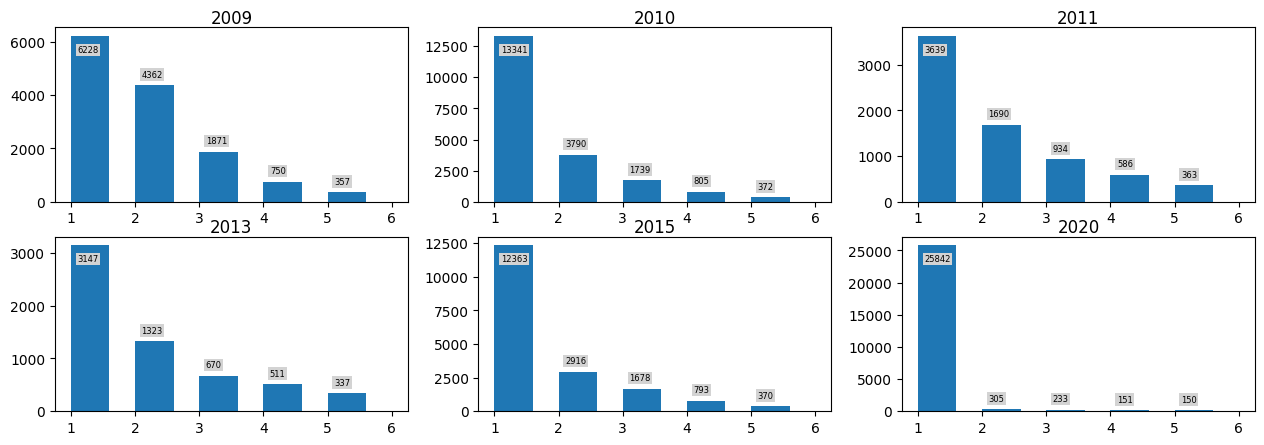

In [4]:
mulv = df.pivot_table(
    columns="SY_MODELO_URNA",
    values="SY_COUNT",
    aggfunc=np.sum,
    fill_value=0,
    index=[df.SG_UF, df.NR_ZONA, df.NR_LOCAL_VOTACAO]
)
mulv["SY_MODELOS_DISTINTOS"] = mulv.astype(bool).sum(axis=1)
mulv = mulv.reset_index().rename_axis(None, axis=1)
mulv.to_csv("urnas_por_local_votacao.csv")


fig, axs = plt.subplots(2,3)
plt.rcParams['axes.titlepad'] = -30
plt.subplots_adjust(bottom=0.1, right=2, top=0.9)

for index, modelo in enumerate(MODELOS):
    ax = axs[index // 3, index % 3]
    counts, bins, patches = ax.hist(mulv[mulv[modelo] > 0].SY_MODELOS_DISTINTOS, bins=5, width=0.6)
    maximum = max(*counts)
    for bin, count in zip(bins, counts):
        y = count + maximum * 0.05 if count < maximum * 0.95 else count - maximum * 0.1
        ax.text(bin + 0.1, y, str(int(count)), fontsize=6, bbox=dict(boxstyle="square,pad=0.2", fc="lightgray", ec="none"))
    ax.grid(False)
    ax.set_title(modelo)
